In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import cifar10
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import time
import os

# Hopfield-like Network for Denoising
class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train(self, patterns):
        for p in patterns:
            self.weights += np.outer(p, p)
        np.fill_diagonal(self.weights, 0)

    def run(self, pattern, steps=5):
        result = np.copy(pattern)
        for _ in range(steps):
            for i in range(self.size):
                result[i] = 1 if np.dot(self.weights[i], result) >= 0 else -1
        return result

# 1. Load CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Reduce the dataset size for quicker experimentation
x_train, y_train = x_train[:5000], y_train[:5000]  # Reduced training samples
x_test, y_test = x_test[:1000], y_test[:1000]      # Reduced test samples

# 2. Preprocess the data (Resizing images and normalizing pixel values)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Introduce Gaussian Noise
def add_noise(data, noise_factor=0.1):
    noise = noise_factor * np.random.randn(*data.shape)
    noisy_data = data + noise
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

x_train_noisy = add_noise(x_train, noise_factor=0.1)
x_test_noisy = add_noise(x_test, noise_factor=0.1)

# Apply Hopfield-like denoising
def apply_hopfield_denoising(data, size):
    data_flat = data.reshape(data.shape[0], -1)  # Flatten images
    data_bipolar = np.where(data_flat > 0.5, 1, -1)  # Convert to bipolar

    # Initialize Hopfield Network
    hopfield = HopfieldNetwork(size)
    hopfield.train(data_bipolar[:50])  # Train with the first 50 images for simplicity

    # Denoise each image
    denoised_data = np.array([hopfield.run(img) for img in data_bipolar])
    return denoised_data.reshape(data.shape)  # Reshape to original dimensions

# Denoise using Hopfield Network
x_train_denoised = apply_hopfield_denoising(x_train_noisy, size=x_train_noisy.shape[1] * x_train_noisy.shape[2] * x_train_noisy.shape[3])
x_test_denoised = apply_hopfield_denoising(x_test_noisy, size=x_test_noisy.shape[1] * x_test_noisy.shape[2] * x_test_noisy.shape[3])

# Check if the VGG16 features are pre-extracted
if not os.path.exists('x_train_vgg_features.npy') or not os.path.exists('x_test_vgg_features.npy'):
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    def extract_features(model, data):
        features = model.predict(data, batch_size=64)  # Batch processing for speed
        return features.reshape(features.shape[0], -1)

    x_train_features = extract_features(vgg, x_train_denoised)
    x_test_features = extract_features(vgg, x_test_denoised)

    # Save features to avoid repeating extraction
    np.save('x_train_vgg_features.npy', x_train_features)
    np.save('x_test_vgg_features.npy', x_test_features)
else:
    # Load pre-extracted features
    x_train_features = np.load('x_train_vgg_features.npy')
    x_test_features = np.load('x_test_vgg_features.npy')

# 4. Standardize the features
scaler = StandardScaler()
x_train_features = scaler.fit_transform(x_train_features)
x_test_features = scaler.transform(x_test_features)

# Initialize a dictionary to store accuracy and training time for each model
results = {}

# 5. SVM with Hyperparameter Tuning using GridSearchCV
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3, verbose=1)
start_time = time.time()
svm_grid.fit(x_train_features, y_train)
y_pred_svm = svm_grid.predict(x_test_features)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
results['SVM'] = {'accuracy': svm_accuracy, 'training_time': time.time() - start_time, 'best_params': svm_grid.best_params_}

# 6. Random Forest with Hyperparameter Tuning using GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, verbose=1)
start_time = time.time()
rf_grid.fit(x_train_features, y_train)
y_pred_rf = rf_grid.predict(x_test_features)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
results['Random Forest'] = {'accuracy': rf_accuracy, 'training_time': time.time() - start_time, 'best_params': rf_grid.best_params_}

# 7. Decision Tree (as before, no tuning here for simplicity)
start_time = time.time()
tree_model = DecisionTreeClassifier(max_depth=20)
tree_model.fit(x_train_features, y_train)
y_pred_tree = tree_model.predict(x_test_features)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
results['Decision Tree'] = {'accuracy': tree_accuracy, 'training_time': time.time() - start_time}

# 8. Multilayer Perceptron (MLP) Classifier
start_time = time.time()
mlp_model = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=100, alpha=0.0001, verbose=1)
mlp_model.fit(x_train_features, y_train)
y_pred_mlp = mlp_model.predict(x_test_features)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
results['MLP'] = {'accuracy': mlp_accuracy, 'training_time': time.time() - start_time}

# 9. Ensemble Classifier
ensemble_model = VotingClassifier(
    estimators=[('svm', svm_grid.best_estimator_), ('mlp', mlp_model), ('rf', rf_grid.best_estimator_)],
    voting='hard'
)
ensemble_model.fit(x_train_features, y_train)
y_pred_ensemble = ensemble_model.predict(x_test_features)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
results['Ensemble'] = {'accuracy': ensemble_accuracy, 'training_time': time.time() - start_time}

# 10. Print Results
for model, result in results.items():
    print(f"{model} - Accuracy: {result['accuracy'] * 100:.2f}%, Training Time: {result['training_time']:.2f} seconds, Best Params: {result.get('best_params', 'N/A')}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Iteration 1, loss = 1.80732181
Iteration 2, loss = 1.19375559
Iteration 3, loss = 0.94616224
Iteration 4, loss = 0.77062703
Iteration 5, loss = 0.62999137
Iteration 6, loss = 0.50626144
Iteration 7, loss = 0.40385105
Iteration 8, loss = 0.32286582
Iteration 9, loss = 0.24628710
Iteration 10, loss = 0.18104902
Iteration 11, loss = 0.13701797
Iteration 12, loss = 0.10233375
Iteration 13, loss = 0.07608222
Iteration 14, loss = 0.05610458
Iteration 15, loss = 0.04175377
Iteration 16, loss = 0.03194851
Iteration 17, loss = 0.02494972
Iteration 18, loss = 0.02161639
Iteration 19, loss = 0.01688047
Iteration 20, loss = 0.01387537
Iteration 21, loss = 0.01154461
Iteration 22, loss = 0.01001657
Iteration 23, loss = 0.00890232
Iteration 24, loss = 0.00781221
Iteration 25, loss = 0.00698221
Iteration 26, loss = 0.00632321
Iteration 27, loss = 0.00570571
Iteration 28, loss = 0.

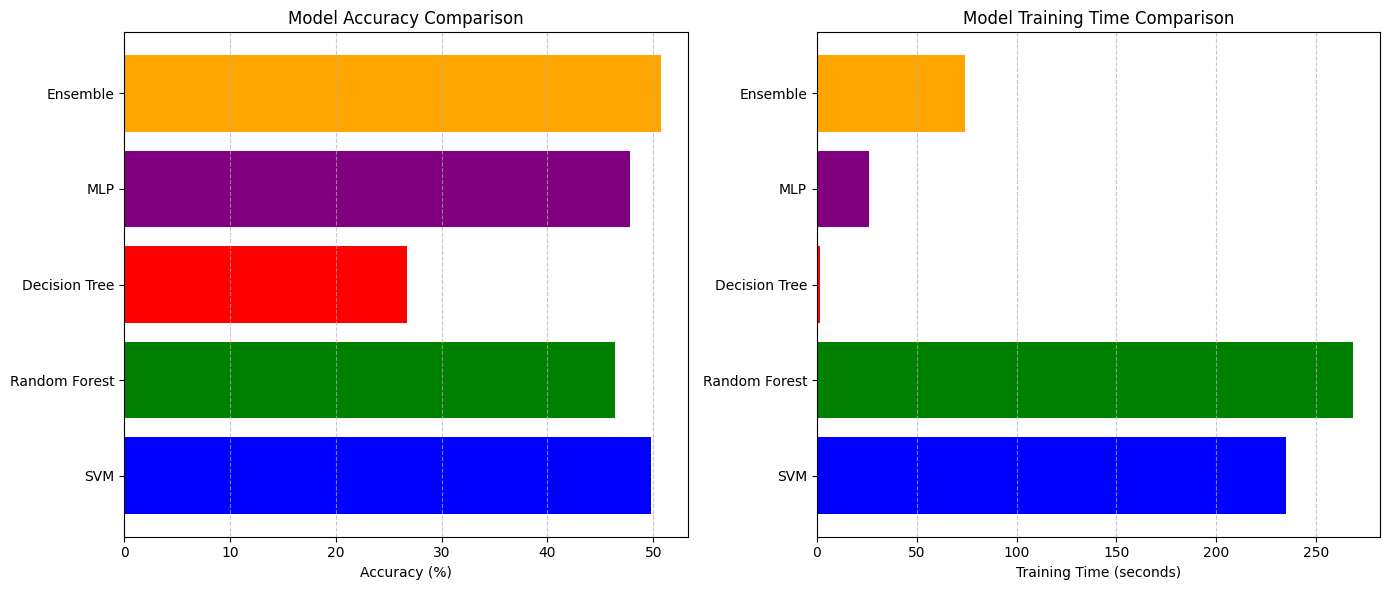

In [6]:
import matplotlib.pyplot as plt

# Data for plotting
model_names = ["SVM", "Random Forest", "Decision Tree", "MLP", "Ensemble"]
accuracies = [49.80, 46.40, 26.70, 47.80, 50.70]
training_times = [234.97, 268.63, 1.50, 26.18, 74.25]

# Plotting accuracy comparison
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.barh(model_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Plotting training time comparison
plt.subplot(1, 2, 2)
plt.barh(model_names, training_times, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Training Time (seconds)')
plt.title('Model Training Time Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
